# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [1]:
import pandas as pd

flights = pd.read_csv('flights_2019_passengers.csv', delimiter=',')
flights = flights.drop('Unnamed: 0', axis=1)
flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,longest_add_gtime,no_name,dep_condition,arr_date,arr_condition,month,year,average_seats,average_passengers,avg_passenger_capacity_usage
0,2019-01-01,AA,AA_CODESHARE,AA,3044,OO,N761ND,3044,13930,ORD,...,NaN,NaN,Overcast,2019-01-01,Partly cloudy,1,2019,1002.000000,777.666667,0.776114
1,2019-01-01,AA,AA_CODESHARE,AA,5606,OH,N575NN,5606,13577,MYR,...,NaN,NaN,Cloudy,2019-01-01,Sunny,1,2019,6327.333333,4898.333333,0.774154
2,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,10529,BDL,...,NaN,NaN,Sunny,2019-01-01,Sunny,1,2019,3516.500000,2697.250000,0.767027
3,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,11278,DCA,...,NaN,NaN,Sunny,2019-01-01,Sunny,1,2019,3460.000000,2494.500000,0.720954
4,2019-01-01,AA,AA_CODESHARE,AA,5608,OH,N710PS,5608,11278,DCA,...,NaN,NaN,Sunny,2019-01-01,Partly cloudy,1,2019,1511.000000,847.333333,0.560777


In [2]:
# Outlier detection 

# Finding the IQR
percentile25 = flights['arr_delay'].quantile(0.25)
percentile75 = flights['arr_delay'].quantile(0.75)
iqr = percentile75 - percentile25

# Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Finding Outliers
flights[flights['arr_delay'] > upper_limit]
flights[flights['arr_delay'] < lower_limit]

# Trimming
flights = flights[(flights['arr_delay'] < upper_limit) & (flights['arr_delay'] > lower_limit)]
flights.shape

(106319, 50)

C:\Users\Irene\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Irene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


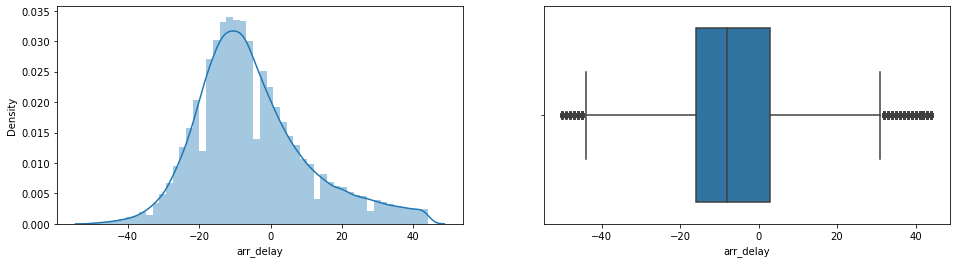

In [3]:
# Compare the plots after trimming
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.distplot(flights['arr_delay'])
plt.subplot(1,2,2)
sns.boxplot(flights['arr_delay'])

plt.show()

In [4]:
import datetime as dt
flights['Month'] = pd.to_datetime(flights['fl_date']).dt.month

In [5]:
# Dropping non-relevant columns

new_flights = flights.drop(['branded_code_share','mkt_carrier','mkt_carrier_fl_num','op_unique_carrier',
                                'cancelled','cancellation_code','diverted','dup','first_dep_time', 
                                'total_add_gtime','longest_add_gtime', 'no_name', 'origin_airport_id',
                                'origin_city_name','dest_airport_id','dest_city_name', 'dep_time', 
                                'dep_delay','taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','flights',
                               'fl_date','tail_num','op_carrier_fl_num','arr_date','average_seats',
                            'Month','year'], axis=1)
new_flights_delay = new_flights[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay']]
new_flights = new_flights.drop(['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'], axis=1)

new_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106319 entries, 1 to 119999
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   mkt_unique_carrier            106319 non-null  object 
 1   origin                        106319 non-null  object 
 2   dest                          106319 non-null  object 
 3   crs_dep_time                  106319 non-null  int64  
 4   crs_arr_time                  106319 non-null  int64  
 5   arr_time                      106319 non-null  float64
 6   arr_delay                     106319 non-null  float64
 7   crs_elapsed_time              106319 non-null  int64  
 8   actual_elapsed_time           106319 non-null  float64
 9   air_time                      106319 non-null  float64
 10  distance                      106319 non-null  int64  
 11  dep_condition                 106319 non-null  object 
 12  arr_condition                 106319 non-nul

In [6]:
counts= new_flights['origin'].value_counts()
new_flights = new_flights[~new_flights['origin'].isin(counts[counts < 100].index)] 
# ~ is the negation operator.

In [7]:
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99166,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199
99167,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199
99168,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004
99169,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795


In [8]:
def simple_weather(row):
    if row in ['Sunny', 'Clear']:
        return 'Sunny'
    
    elif row in ['Partly cloudy','Overcast','Cloudy']:
        return 'Cloudy'
    
    elif row in ['Torrential rain shower', 'Heavy rain', 'Heavy rain at times']:
        return 'Heavy_rain'

    elif row in ['Moderate rain', 'Moderate rain at times',
                                  'Moderate or heavy rain with thunder']:
        return 'Moderate_rain'
    
    elif row in ['Patchy rain possible','Light rain shower','Light drizzle','Light rain',
                                  'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain']:
        return 'Light_rain'
    
    elif row in ['Moderate or heavy freezing rain']:
        return 'Freezing_rain'
    
    elif row in ['Mist','Fog', 'Freezing fog']:
        return 'Fog'
    
    elif row in ['Heavy snow', 'Moderate or heavy snow showers', 'Patchy heavy snow', 
                                  'Blizzard', 'Blowing snow', 'Ice pellets']:
        return 'Heavy_snow'
    
    elif row in ['Moderate snow', 'Moderate or heavy snow showers','Patchy moderate snow',
                                  'Moderate or heavy sleet', 'Moderate or heavy snow with thunder']:
        return 'Moderate_snow'
    
    elif row in ['Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',
                                  'Patchy sleet possible', 'Light snow showers', 
                                  'Patchy light snow with thunder', 'Patchy snow possible']:
        return 'Light_snow'
    
    elif row in ['Thundery outbreaks possible']:
        return 'Thunder'


In [9]:
new_flights['weather_origin_simple'] = new_flights.apply(lambda row: simple_weather(row['dep_condition']), axis=1)
new_flights['weather_origin_simple'].value_counts()

Sunny            51990
Cloudy           28889
Light_rain       10402
Heavy_snow        1127
Moderate_rain     1070
Light_snow        1031
Fog                886
Moderate_snow      369
Heavy_rain         280
Thunder             71
Freezing_rain       27
Name: weather_origin_simple, dtype: int64

In [10]:
wt_counts= new_flights['weather_origin_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_origin_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,weather_origin_simple
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154,Cloudy
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027,Sunny
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954,Sunny
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777,Sunny
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99068,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy
99069,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy
99070,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004,Cloudy
99071,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795,Moderate_rain


In [11]:
new_flights['weather_dest_simple'] = new_flights.apply(lambda row: simple_weather(row['arr_condition']), axis=1)
new_flights['weather_dest_simple'].value_counts()

Sunny            51336
Cloudy           28800
Light_rain       10530
Heavy_snow        1501
Light_snow        1153
Moderate_rain     1151
Fog                870
Moderate_snow      452
Heavy_rain         274
Thunder            114
Freezing_rain       28
Name: weather_dest_simple, dtype: int64

In [12]:
wt_counts= new_flights['weather_dest_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_dest_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,weather_origin_simple,weather_dest_simple
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154,Cloudy,Sunny
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027,Sunny,Sunny
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954,Sunny,Sunny
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777,Sunny,Cloudy
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359,Cloudy,Sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99040,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy,Moderate_rain
99041,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy,Moderate_rain
99042,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004,Cloudy,Heavy_snow
99043,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795,Moderate_rain,Sunny


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [14]:
# One hot encoding for origin and unique_carrier and weather
# are these too many columns now? - to discuss

'''#not much relevance in origin and arrival delay(p-value is high) in linear regression?'''
onehot_origin = pd.get_dummies(new_flights['origin'])
new_flights = new_flights.drop('origin', axis=1)
new_flights = new_flights.join(onehot_origin)
new_flights = new_flights.drop('dest', axis=1)

onehot_carrier = pd.get_dummies(new_flights['mkt_unique_carrier'])
new_flights = new_flights.drop('mkt_unique_carrier', axis=1)
new_flights = new_flights.join(onehot_carrier)

onehot_weather = pd.get_dummies(new_flights[['weather_origin_simple','weather_dest_simple']])
new_flights = new_flights.drop(['weather_origin_simple','dep_condition','weather_dest_simple',
                                'arr_condition'], axis=1)
new_flights = new_flights.join(onehot_weather)


In [15]:
new_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99045 entries, 0 to 99044
Columns: 156 entries, crs_dep_time to weather_dest_simple_Thunder
dtypes: float64(6), int64(5), uint8(145)
memory usage: 22.0 MB


In [25]:
y = new_flights['arr_delay']
X = new_flights.drop('arr_delay', axis=1)

In [26]:
X.head()

,crs_dep_time,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,average_passengers,avg_passenger_capacity_usage,...,weather_dest_simple_Cloudy,weather_dest_simple_Fog,weather_dest_simple_Heavy_rain,weather_dest_simple_Heavy_snow,weather_dest_simple_Light_rain,weather_dest_simple_Light_snow,weather_dest_simple_Moderate_rain,weather_dest_simple_Moderate_snow,weather_dest_simple_Sunny,weather_dest_simple_Thunder
0,2157,2311,2308.0,74,70.0,40.0,157,1,4898.333333,0.774154,...,0,0,0,0,0,0,0,0,1,0
1,1151,1325,1331.0,94,79.0,69.0,313,1,2697.250000,0.767027,...,0,0,0,0,0,0,0,0,1,0
2,1009,1126,1140.0,77,87.0,52.0,313,1,2494.500000,0.720954,...,0,0,0,0,0,0,0,0,1,0
3,2000,2134,2122.0,94,87.0,72.0,396,1,847.333333,0.560777,...,1,0,0,0,0,0,0,0,0,0
4,1215,1347,1333.0,92,88.0,66.0,290,1,4888.750000,0.798359,...,0,0,0,0,0,0,0,0,1,0


C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
#PCA
pca = PCA(n_components=10)
pca.fit(X_scaled)


In [ ]:
X_pca = pca.transform(X_scaled)
X_pca.shape

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1], c=y) #Not so useful


In [ ]:
comp = X_scaled == X_transform

##### variance threshold

In [28]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.9)
X_transform = vt.fit_transform(X_scaled)

In [29]:
X_transform.shape

(99045, 155)

In [30]:
# columns we have selected
# get_support() is method of VarianceThreshold and stores boolean of each variable in the numpy array.
selected_columns = X.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
X_transform = pd.DataFrame(X_transform, columns = selected_columns)

In [31]:
X_transform

,crs_dep_time,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,average_passengers,avg_passenger_capacity_usage,...,weather_dest_simple_Cloudy,weather_dest_simple_Fog,weather_dest_simple_Heavy_rain,weather_dest_simple_Heavy_snow,weather_dest_simple_Light_rain,weather_dest_simple_Light_snow,weather_dest_simple_Moderate_rain,weather_dest_simple_Moderate_snow,weather_dest_simple_Sunny,weather_dest_simple_Thunder
0,1.684998,1.592747,1.598011,-0.947126,-0.910120,-1.032332,-1.116504,-1.605500,0.114193,-0.526077,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,0.964027,-0.033946
1,-0.365333,-0.307829,-0.269663,-0.665121,-0.782861,-0.611355,-0.847007,-1.605500,-0.541082,-0.611766,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,0.964027,-0.033946
2,-0.654743,-0.691413,-0.634786,-0.904826,-0.669741,-0.858134,-0.847007,-1.605500,-0.601442,-1.165666,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,0.964027,-0.033946
3,1.365016,1.251569,1.242446,-0.665121,-0.669741,-0.567805,-0.703621,-1.605500,-1.091813,-3.091348,...,1.561750,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,-1.037315,-0.033946
4,-0.234894,-0.265422,-0.265839,-0.693322,-0.655601,-0.654904,-0.886741,-1.605500,0.111340,-0.235087,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,0.964027,-0.033946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99040,1.793018,1.677560,-2.775825,-0.510019,-0.344523,-0.379092,-0.342564,1.590244,-0.209115,-0.477449,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,9.222324,-0.067709,-1.037315,-0.033946
99041,-1.457755,-1.319798,-1.256070,-0.510019,-0.330383,-0.277476,-0.342564,1.590244,-0.209115,-0.477449,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,9.222324,-0.067709,-1.037315,-0.033946
99042,-0.805563,0.068046,0.103108,1.182011,1.422969,1.420948,1.564645,1.590244,-0.572713,0.013109,...,-0.640307,-0.094137,-0.05267,8.061390,-0.34491,-0.108528,-0.108433,-0.067709,-1.037315,-0.033946
99043,-1.661566,-0.857184,-0.868006,0.900006,0.616992,0.767708,1.210498,1.590244,-0.668385,1.044506,...,-0.640307,-0.094137,-0.05267,-0.124048,-0.34491,-0.108528,-0.108433,-0.067709,0.964027,-0.033946


In [32]:
import numpy as np 

# step 1
X_corr = X_transform.corr().abs()

# step 2
indices = np.where(X_corr > 0.8) 
indices = [(X_corr.index[x], X.columns[y]) 
for x, y in zip(*indices)
    if x != y and x < y]

# step 3
for idx in indices: #each pair
    try:
        X_transform.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [33]:
print(indices)

[('crs_arr_time', 'arr_time'), ('crs_elapsed_time', 'actual_elapsed_time'), ('crs_elapsed_time', 'air_time'), ('crs_elapsed_time', 'distance'), ('actual_elapsed_time', 'air_time'), ('actual_elapsed_time', 'distance'), ('air_time', 'distance')]


In [34]:
X_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99045 entries, 0 to 99044
Columns: 151 entries, crs_dep_time to weather_dest_simple_Thunder
dtypes: float64(151)
memory usage: 114.1 MB


In [48]:
# Forward Regression

from sklearn.feature_selection import f_regression, SelectKBest
skb = SelectKBest(f_regression, k=30)
X = skb.fit_transform(X_transform, y)

In [49]:
# this will give us the position of top 10 columns
skb.get_support()
# column names
X_transform.columns[skb.get_support()]
X = pd.DataFrame(X,columns=X_transform.columns[skb.get_support()])

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99045 entries, 0 to 99044
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   crs_dep_time                         99045 non-null  float64
 1   crs_arr_time                         99045 non-null  float64
 2   crs_elapsed_time                     99045 non-null  float64
 3   month                                99045 non-null  float64
 4   BWI                                  99045 non-null  float64
 5   DAL                                  99045 non-null  float64
 6   DEN                                  99045 non-null  float64
 7   DFW                                  99045 non-null  float64
 8   JFK                                  99045 non-null  float64
 9   LAX                                  99045 non-null  float64
 10  LGA                                  99045 non-null  float64
 11  MDW                         

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
!pip install pandas-profiling[notebook]

#####  #1. Linear Regression

In [46]:
import statsmodels.api as sm
X = sm.add_constant(X) # adding a constant

C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
y = list(y)

lin_reg = sm.OLS(y,X_scaled)
# performing the regression
# and fitting the model
result = sm.OLS(y, X_scaled).fit()
 
# printing the summary table
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.398
Model:                            OLS   Adj. R-squared (uncentered):              0.397
Method:                 Least Squares   F-statistic:                              427.4
Date:                Thu, 04 Aug 2022   Prob (F-statistic):                        0.00
Time:                        00:04:59   Log-Likelihood:                     -3.9354e+05
No. Observations:               99045   AIC:                                  7.874e+05
Df Residuals:                   98892   BIC:                                  7.888e+05
Df Model:                         153                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [56]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_scaled, y)

regressor.score(X_scaled,y) # R-squared

[ 1.30378461e+00  5.35891016e-01 -2.74930562e-01 -6.02460592e+01
  6.43538375e+01 -3.96251985e+00  1.21305381e-01 -6.02967583e-01
  1.96514989e-02  6.57401260e-01 -2.71435291e+10 -1.93607959e+10
 -1.93194802e+10 -8.99234908e+10 -4.37542304e+10 -1.30391512e+10
 -2.60974292e+10 -2.19144621e+10 -5.01667421e+10 -2.36643309e+10
 -5.15857167e+10 -1.44382775e+10 -2.42958212e+10 -3.33358695e+10
 -5.74894635e+10 -1.33427978e+10 -2.31534446e+10 -1.31004461e+10
 -3.32407525e+10 -6.60509895e+10 -3.39707440e+10 -1.48213794e+10
 -3.17539244e+10 -5.26708983e+10 -1.59151515e+10 -5.02286557e+10
 -7.99665372e+10 -7.65800710e+10 -1.90277343e+10 -5.76496830e+10
 -1.27282311e+10 -2.29110782e+10 -5.01047467e+10 -1.61646034e+10
 -4.58325373e+10 -2.02087390e+10 -2.00101396e+10 -1.66041142e+10
 -1.87314026e+10 -3.45478848e+10 -4.60366303e+10 -1.27282311e+10
 -1.35808063e+10 -4.40929825e+10 -6.13083598e+10 -1.48752985e+10
 -1.27282311e+10 -3.21507467e+10 -1.27910223e+10 -2.57906099e+10
 -4.42878575e+10 -1.86029

0.4355788304550844

#####  #2. Multinomial Logistic Regression

In [53]:
# Step 1: Import Packages, Functions, and Classes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Get Data - We already have X, y

In [54]:
X

,crs_dep_time,crs_arr_time,crs_elapsed_time,month,BWI,DAL,DEN,DFW,JFK,LAX,...,weather_origin_simple_Heavy_snow,weather_origin_simple_Light_snow,weather_origin_simple_Moderate_rain,weather_origin_simple_Moderate_snow,weather_origin_simple_Sunny,weather_dest_simple_Fog,weather_dest_simple_Heavy_snow,weather_dest_simple_Light_snow,weather_dest_simple_Moderate_rain,weather_dest_simple_Sunny
0,1.684998,1.592747,-0.947126,-1.605500,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,-1.050961,-0.094137,-0.124048,-0.108528,-0.108433,0.964027
1,-0.365333,-0.307829,-0.665121,-1.605500,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,0.951510,-0.094137,-0.124048,-0.108528,-0.108433,0.964027
2,-0.654743,-0.691413,-0.904826,-1.605500,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,0.951510,-0.094137,-0.124048,-0.108528,-0.108433,0.964027
3,1.365016,1.251569,-0.665121,-1.605500,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,0.951510,-0.094137,-0.124048,-0.108528,-0.108433,-1.037315
4,-0.234894,-0.265422,-0.693322,-1.605500,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,-1.050961,-0.094137,-0.124048,-0.108528,-0.108433,0.964027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99040,1.793018,1.677560,-0.510019,1.590244,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,-1.050961,-0.094137,-0.124048,-0.108528,9.222324,-1.037315
99041,-1.457755,-1.319798,-0.510019,1.590244,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,-1.050961,-0.094137,-0.124048,-0.108528,9.222324,-1.037315
99042,-0.805563,0.068046,1.182011,1.590244,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,-0.104059,-0.061068,-1.050961,-0.094137,8.061390,-0.108528,-0.108433,-1.037315
99043,-1.661566,-0.857184,0.900006,1.590244,-0.147287,-0.134465,-0.209307,-0.199688,-0.11246,-0.192864,...,-0.107283,-0.102511,9.609923,-0.061068,-1.050961,-0.094137,-0.124048,-0.108528,-0.108433,0.964027


In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
'''

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
'''
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Step 3: Create a Model and Train It
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
'''

The “saga” solver 7 is a variant of “sag” that also supports the non-smooth penalty="l1". This is therefore the solver of choice for sparse multinomial logistic regression. It is also the only solver that supports penalty="elasticnet".

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1", max_iter=500, multi_class = 'multinomial', solver='saga')
# training the model
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

#####  #3. Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor # Import Random Forest Classifier
regr = RandomForestRegressor(max_depth=10)
regr.fit(X_train, y_train)


In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
regr.predict(X_test.iloc[[0]])

In [ ]:
y_test.iloc[[0]]

#####  #4. Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

mse = mean_squared_error(y_test, y_pred, squared=False)
print("MSE: {:.2f}".format(mse))

#####  #5. SVM

In [ ]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

X_train_scaled = transform(X_train)
X_test_scaled = transform(X_test)

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel= 'poly', random_state=0)  #use the Polynomial kernel (polynomial linear regression)
clf.fit(X_train, y_train)

In [ ]:
# Predict the Test set results
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# use rbf kernel
clf_rbf = SVC(kernel= 'rbf', random_state=0)

#####  #6. XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.